# Model Prototype

Training an LSTM model to predict future bitcoin prices given the return values and trend values

In [1]:
from pandas import read_csv, DataFrame, concat

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, Activation, Dense, Dropout, Flatten
from keras.layers import LSTM
from keras import Model
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

Using TensorFlow backend.


### Load and reshape data

In [2]:
# load dataset and separate dates
btc_df = read_csv('../data/processed/price_trend_data.csv')
dates = btc_df.date
dataset_raw = btc_df.drop('date', axis=1)

In [3]:
# reshape the data so that y is the next time step with forecast sequence
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# reshape time series
look_back = 10
dataset = series_to_supervised(dataset_raw, n_in=look_back)
# drop var2(t) since var1(t) is target
dataset.drop(dataset.columns[len(dataset.columns)-1], axis=1, inplace=True)

In [4]:
dataset.head()

,var1(t-10),var2(t-10),var1(t-9),var2(t-9),var1(t-8),var2(t-8),var1(t-7),var2(t-7),var1(t-6),var2(t-6),...,var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
10,0.122602,0.039388,0.109199,0.020147,-0.148420,0.048620,0.076961,0.082611,0.259511,0.020946,...,-0.172811,0.000000,0.049526,0.000000,0.004901,0.000000,0.025209,-0.101783,0.051031,-0.036368
11,0.109199,0.020147,-0.148420,0.048620,0.076961,0.082611,0.259511,0.020946,-0.121361,-0.172811,...,0.049526,0.000000,0.004901,0.000000,0.025209,-0.101783,0.051031,-0.036368,-0.057106,0.000000
12,-0.148420,0.048620,0.076961,0.082611,0.259511,0.020946,-0.121361,-0.172811,0.000000,0.049526,...,0.004901,0.000000,0.025209,-0.101783,0.051031,-0.036368,-0.057106,0.000000,-0.025840,0.036368
13,0.076961,0.082611,0.259511,0.020946,-0.121361,-0.172811,0.000000,0.049526,0.000000,0.004901,...,0.025209,-0.101783,0.051031,-0.036368,-0.057106,0.000000,-0.025840,0.036368,-0.009472,0.000000
14,0.259511,0.020946,-0.121361,-0.172811,0.000000,0.049526,0.000000,0.004901,0.000000,0.025209,...,0.051031,-0.036368,-0.057106,0.000000,-0.025840,0.036368,-0.009472,0.000000,0.032621,0.164303


In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset.values[:train_size], dataset.values[train_size:len(dataset)]

# split in X and y
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features] for LSTM input
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# scale on training data
scalers = {}
for i in range(X_train.shape[2]):
    scalers[i] = StandardScaler()
    X_train[:, :, i] = scalers[i].fit_transform(X_train[:, :, i])

for i in range(X_test.shape[2]):
    X_test[:, :, i] = scalers[i].transform(X_test[:, :, i])
    
scale_y = StandardScaler()
y_train = scale_y.fit_transform(y_train.reshape(-1, 1))
y_test = scale_y.transform(y_test.reshape(-1, 1))

### Dummy comparison models

In [6]:
# evaluate dummy models for comparison
for strategy in ['mean', 'median', 'constant']:
    
    if strategy=='constant':
        dummy=DummyRegressor(strategy=strategy, constant=(0,))
    else:
        dummy=DummyRegressor(strategy=strategy)
        
    print('\nTraining dummy model on training data with strategy {} ...'.format(strategy))
    dummy.fit(X_train, y_train)
    
    print('\nPerformance on train data:')
    dummy_predict_train = dummy.predict(X_train)
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_train, y_pred=dummy_predict_train)))
    
    print('\nPerformance on test data:')
    dummy_predict_test = dummy.predict(X_test)
    print('{} MSE: {}'.format(strategy, mean_squared_error(y_true=y_test, y_pred=dummy_predict_test)))


Training dummy model on training data with strategy mean ...

Performance on train data:
mean MSE: 0.9999999999999999

Performance on test data:
mean MSE: 1.0349459376817913

Training dummy model on training data with strategy median ...

Performance on train data:
median MSE: 1.0000765511111582

Performance on test data:
median MSE: 1.0345844877355812

Training dummy model on training data with strategy constant ...

Performance on train data:
constant MSE: 0.9999999999999999

Performance on test data:
constant MSE: 1.0349459376817913


### LSTM Model

As this is just an expository project we aren't looking for fantastic results. For one, the dataset being used is very small compared to the data required to get good results with an LSTM. Additionally, the parameters dropout, nodes, epochs, and batch_size were tuned by hand due to computation constraints. With more resources the parameters could be better tuned by using a nested cross-validation technique such as day forward-chaining. 

In [7]:
dropout = 0.8
nodes = 64
epochs = 100
batch_size = 25

model = Sequential()
model.add(LSTM(nodes, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))
model.add(LSTM(nodes))
model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=epochs, verbose=1, shuffle=False, 
                    batch_size=batch_size, validation_data=(X_test, y_test))
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1465 samples, validate on 629 samples
Epoch 1/100
1465/1465 [==============================] - 4s 3ms/step - loss: 0.9971 - val_loss: 1.0104
Epoch 2/100
1465/1465 [==============================] - 1s 594us/step - loss: 0.9797 - val_loss: 0.9804
Epoch 3/100
1465/1465 [==============================] - 1s 578us/step - loss: 0.9597 - val_loss: 0.9425
Epoch 4/100
1465/1465 [==============================] - 1s 479us/step - loss: 0.9203 - val_loss: 0.8999
Epoch 5/100
1465/1465 [==============================] - 1s 551us/step - loss: 0.9037 - val_loss: 0.8787
Epoch 6/100
1465/1465 [==============================] - 1s 487us/step - loss: 0.8882 - val_loss: 0.8664
Epoch 7/100
1465/1465 [==============================] - 1s 528us/step - loss: 0.8890 - val_loss: 0.8563
Epoch

1465/1465 [==============================] - 1s 366us/step - loss: 0.7131 - val_loss: 0.7768
Epoch 59/100
1465/1465 [==============================] - 1s 395us/step - loss: 0.7070 - val_loss: 0.7794
Epoch 60/100
1465/1465 [==============================] - 1s 508us/step - loss: 0.6996 - val_loss: 0.7721
Epoch 61/100
1465/1465 [==============================] - 0s 311us/step - loss: 0.7166 - val_loss: 0.7738
Epoch 62/100
1465/1465 [==============================] - 0s 318us/step - loss: 0.7184 - val_loss: 0.7703
Epoch 63/100
1465/1465 [==============================] - 0s 314us/step - loss: 0.7274 - val_loss: 0.7694
Epoch 64/100
1465/1465 [==============================] - 0s 303us/step - loss: 0.7214 - val_loss: 0.7795
Epoch 65/100
1465/1465 [==============================] - 1s 356us/step - loss: 0.7037 - val_loss: 0.7787
Epoch 66/100
1465/1465 [==============================] - 0s 299us/step - loss: 0.7310 - val_loss: 0.7849
Epoch 67/100
1465/1465 [==============================] - 0

### Diagnostics

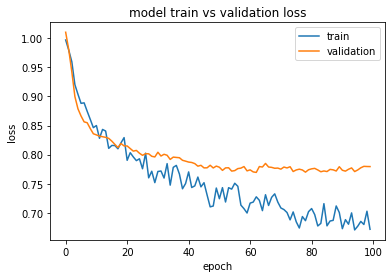

In [8]:
# train and validation loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

The train and validation loss don't quite converge but with such small data these were the best results with tuning by hand. Tuning either way gives clear over- and under-fitting. There is also an interesting occurence where the validation loss is lower than the training loss which can be caused by the validation cases not using dropout in their evaluation, but this still appears when the dropout layer is taken away.

In [9]:
# calculate mean squared error
train_score = mean_squared_error(y_train, train_predict[:,0])
print('Train Score: %.4f MSE' % (train_score))
test_score = mean_squared_error(y_test, test_predict[:,0])
print('Test Score: %.4f MSE' % (test_score))

Train Score: 0.5960 MSE
Test Score: 0.7794 MSE


Significantly better than the dummy cases. Would like to compare to other models such as ARIMA or XGBOOST as well as compare results without using the trend variable. 

In [10]:
# inverse scale target and predictions
y_train = scale_y.inverse_transform(y_train)
y_test = scale_y.inverse_transform(y_test)
test_predict = scale_y.inverse_transform(test_predict)
train_predict = scale_y.inverse_transform(train_predict)

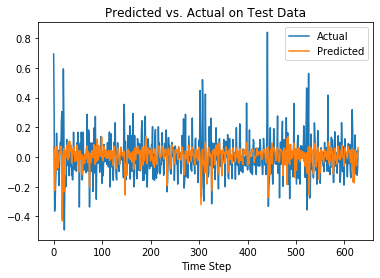

In [11]:
# compare predicitons on test data
plt.plot(y_test)
plt.plot(test_predict)
plt.xlabel('Time Step')
plt.title('Predicted vs. Actual on Test Data')
plt.legend(['Actual', 'Predicted'])
plt.show()

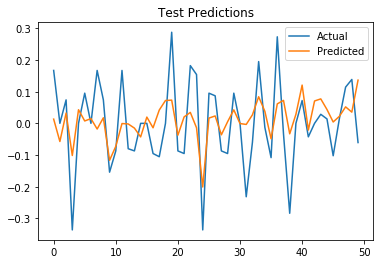

In [12]:
# closer look
plt.plot(y_test[50:100])
plt.plot(test_predict[50:100])
plt.title('Test Predictions')
plt.legend(['Actual', 'Predicted'])
plt.show()

One potential problem with using LSTMs on time-series data is the possibility of the model learning a lagged version of the input, we can see that this isn't the case with these predictions.

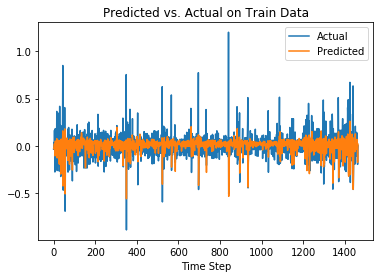

In [13]:
# compare predictions on train data
plt.plot(y_train)
plt.plot(train_predict)
plt.xlabel('Time Step')
plt.title('Predicted vs. Actual on Train Data')
plt.legend(['Actual', 'Predicted'])
plt.show()

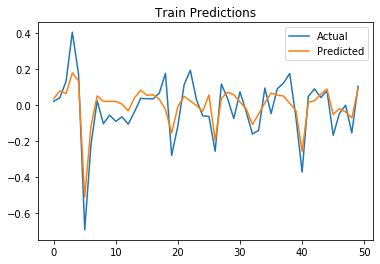

In [14]:
plt.plot(y_train[50:100])
plt.plot(train_predict[50:100])
plt.title('Train Predictions')
plt.legend(['Actual', 'Predicted'])
plt.show()

For the small amount of data used to train the model and the simplicity of the model these results seem like a promising starting point.